[View in Colaboratory](https://colab.research.google.com/github/webserg/pythonML/blob/master/colab/plankton.ipynb)

https://www.kaggle.com/c/datasciencebowl/data
http://benanne.github.io/2015/03/17/plankton.html


In [1]:
!pip install kaggle

  Running setup.py bdist_wheel for kaggle ... - \ done
  Stored in directory: /content/.cache/pip/wheels/d6/3c/92/375decc0cf0a65b281db3cca9b8e21dc27b8ebc4d1ce29afca
Successfully built kaggle


In [2]:
from googleapiclient.discovery import build
import io, os
from googleapiclient.http import MediaIoBaseDownload
from google.colab import auth

auth.authenticate_user()

drive_service = build('drive', 'v3')
results = drive_service.files().list(
        q="name = 'kaggle.json'", fields="files(id)").execute()
kaggle_api_key = results.get('files', [])

filename = "/content/.kaggle/kaggle.json"
os.makedirs(os.path.dirname(filename), exist_ok=True)

request = drive_service.files().get_media(fileId=kaggle_api_key[0]['id'])
fh = io.FileIO(filename, 'wb')
downloader = MediaIoBaseDownload(fh, request)
done = False
while done is False:
    status, done = downloader.next_chunk()
    print("Download %d%%." % int(status.progress() * 100))
os.chmod(filename, 600)

Download 100%.


In [3]:
!kaggle competitions list

ref                                             deadline             category            reward  teamCount  userHasEntered  
----------------------------------------------  -------------------  ---------------  ---------  ---------  --------------  
imagenet-object-detection-challenge             2029-12-31 07:00:00  Research         Knowledge          0           False  
imagenet-object-detection-from-video-challenge  2029-12-31 07:00:00  Research         Knowledge          0           False  
imagenet-object-localization-challenge          2029-12-31 07:00:00  Research         Knowledge          8           False  
titanic                                         2020-04-07 00:00:00  Getting Started  Knowledge      11284            True  
house-prices-advanced-regression-techniques     2020-03-01 23:59:00  Getting Started  Knowledge       5403           False  
digit-recognizer                                2020-01-07 00:00:00  Getting Started  Knowledge       2504           False  


In [4]:
!pwd

/content


In [8]:
!ls -l

total 12
drwxr-xr-x 1 root root 4096 May 20 15:25 datalab
drwxr-xr-x 2 root root 4096 May 20 15:25 datasciencebowl
drwxr-xr-x 2 root root 4096 May 20 15:26 plankton


In [7]:
!kaggle competitions download -c datasciencebowl -p ./plankton

sampleSubmission.csv.zip: Downloaded 886KB of 886KB to ./plankton
train.zip: Downloaded 76MB of 76MB to ./plankton
test.zip: Downloaded 347MB of 347MB to ./plankton
plankton_identification.pdf: Downloaded 2MB of 2MB to ./plankton


In [12]:
%mkdir /content/plankton/validation/
%cd /content/plankton/validation/

/content/plankton/validation


In [13]:
%ls -l

total 0


In [14]:
import zipfile
import os
data_dir = "/content/plankton"
path_to_data = "/content/plankton/train.zip"
path_to_data

'/content/plankton/train.zip'

In [0]:
if os.path.exists(data_dir) == False:
    os.makedirs(data_dir)

In [0]:
zip_ref = zipfile.ZipFile(path_to_data, 'r')
zip_ref.extractall(data_dir)
zip_ref.close()

In [16]:
path_to_test = "/content/plankton/test.zip"
path_to_test

'/content/plankton/test.zip'

In [0]:
 os.makedirs(data_dir + "/test")

In [0]:
zip_ref = zipfile.ZipFile(path_to_test, 'r')
zip_ref.extractall(data_dir + "/test")
zip_ref.close()

In [0]:
validation_dir = os.path.join(data_dir, 'validation')
if os.path.exists(validation_dir) == False:
    os.mkdir(validation_dir)

In [0]:
import shutil
train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'test')

In [0]:
validation_dir = os.path.join(data_dir, 'validation')

dir_info = [x for x in os.walk(train_dir)]
for dir in dir_info[1:]:
    #print(len(dir[2]))
    validation_number = int(round(len(dir[2])/10))
    #print(validation_number)
    #print(dir[2])
    #print(dir[2][:validation_number])
    dir_name = os.path.split(dir[0])[1]
    #print(dir_name)
    validation_dir_current = os.path.join(validation_dir, dir_name)
    if os.path.exists(validation_dir_current) == False:
        os.mkdir(validation_dir_current)
    for fname in dir[2][:validation_number]:
        src = os.path.join(train_dir, dir_name, fname)
        dst = os.path.join(validation_dir_current, fname)
        #print(src)
        #print(dst)
        shutil.move(src, dst)


In [0]:
if os.path.exists(validation_dir) == False:
    print("false")

In [58]:
print('total training categories:', len(os.listdir(train_dir)))
cpt = sum([len(files) for r, d, files in os.walk(train_dir)])
print('all train images: ',cpt )

total training categories: 121
all train images:  17431


In [24]:
print('total validation categories:', len(os.listdir(validation_dir)))
cpt = sum([len(files) for r, d, files in os.walk(validation_dir)])
print('all validation images: ',cpt )

total validation categories: 121
all validation images:  3032


In [50]:
from keras.preprocessing.image import ImageDataGenerator
#train_datagen = ImageDataGenerator(rescale=1./255)
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,)
validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
train_dir,
target_size=(200, 200),
batch_size=20,
class_mode='categorical')
validation_generator = validation_datagen.flow_from_directory(
validation_dir,
target_size=(200, 200),
batch_size=20,
class_mode='categorical')

Found 27304 images belonging to 121 classes.
Found 3032 images belonging to 121 classes.


In [30]:
from keras import layers
from keras import models

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(200, 200, 3)))
model.add(layers.Conv2D(16, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((3, 3),strides=2))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((3, 3),strides=2))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((3, 3),strides=2))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(121, activation='softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 198, 198, 32)      896       
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 196, 196, 16)      4624      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 97, 97, 16)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 95, 95, 64)        9280      
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 93, 93, 32)        18464     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 46, 46, 32)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 44, 44, 128)       36992     
__________

In [0]:
from keras import optimizers
model.compile(loss='categorical_crossentropy',
optimizer=optimizers.Adam(lr=0.001),
metrics=['acc'])

In [32]:
history = model.fit_generator(
train_generator,
steps_per_epoch=150,
epochs=50,
validation_data=validation_generator,
validation_steps=50)
model.save('/content/plankton/plankton_1.h5')

Epoch 1/50
150/150 [==============================] - 44s 294ms/step - loss: 4.3089 - acc: 0.0567 - val_loss: 4.1604 - val_acc: 0.0460
Epoch 2/50
150/150 [==============================] - 40s 268ms/step - loss: 4.2327 - acc: 0.0640 - val_loss: 4.1590 - val_acc: 0.0460
Epoch 3/50
145/150 [============================>.] - ETA: 1s - loss: 4.1953 - acc: 0.0624

150/150 [==============================] - 41s 271ms/step - loss: 4.1910 - acc: 0.0623 - val_loss: 4.1485 - val_acc: 0.0460
Epoch 4/50
150/150 [==============================] - 41s 271ms/step - loss: 4.1973 - acc: 0.0543 - val_loss: 4.1473 - val_acc: 0.0460
Epoch 5/50
150/150 [==============================] - 41s 270ms/step - loss: 4.1940 - acc: 0.0547 - val_loss: 4.1609 - val_acc: 0.0800
Epoch 6/50
 29/150 [====>.........................] - ETA: 26s - loss: 4.1498 - acc: 0.0741

150/150 [==============================] - 41s 273ms/step - loss: 4.1814 - acc: 0.0677 - val_loss: 4.1551 - val_acc: 0.0800
Epoch 7/50
150/150 [==============================] - 41s 270ms/step - loss: 4.1471 - acc: 0.0623 - val_loss: 4.1448 - val_acc: 0.0800
Epoch 8/50
150/150 [==============================] - 40s 267ms/step - loss: 4.1771 - acc: 0.0587 - val_loss: 4.1392 - val_acc: 0.0800
Epoch 9/50
 11/150 [=>............................] - ETA: 20s - loss: 4.1346 - acc: 0.0818

150/150 [==============================] - 40s 268ms/step - loss: 4.1855 - acc: 0.0653 - val_loss: 4.1534 - val_acc: 0.0460
Epoch 10/50
150/150 [==============================] - 41s 270ms/step - loss: 4.1528 - acc: 0.0633 - val_loss: 4.1454 - val_acc: 0.0460
Epoch 11/50
150/150 [==============================] - 40s 270ms/step - loss: 4.1869 - acc: 0.0623 - val_loss: 4.1391 - val_acc: 0.0800
Epoch 12/50
  7/150 [>.............................] - ETA: 21s - loss: 4.2590 - acc: 0.0429

150/150 [==============================] - 41s 271ms/step - loss: 4.1750 - acc: 0.0623 - val_loss: 4.1503 - val_acc: 0.0460
Epoch 13/50
150/150 [==============================] - 41s 273ms/step - loss: 4.1735 - acc: 0.0627 - val_loss: 4.1441 - val_acc: 0.0460
Epoch 14/50
150/150 [==============================] - 41s 271ms/step - loss: 4.1619 - acc: 0.0657 - val_loss: 4.1389 - val_acc: 0.0460
Epoch 15/50
  6/150 [>.............................] - ETA: 21s - loss: 4.1403 - acc: 0.0750

150/150 [==============================] - 41s 270ms/step - loss: 4.1753 - acc: 0.0657 - val_loss: 4.1419 - val_acc: 0.0460
Epoch 16/50
150/150 [==============================] - 41s 271ms/step - loss: 4.1642 - acc: 0.0670 - val_loss: 4.1362 - val_acc: 0.0800
Epoch 17/50
150/150 [==============================] - 41s 270ms/step - loss: 4.1721 - acc: 0.0640 - val_loss: 4.1349 - val_acc: 0.0800
Epoch 18/50
  6/150 [>.............................] - ETA: 21s - loss: 4.1115 - acc: 0.0667

150/150 [==============================] - 41s 271ms/step - loss: 4.1834 - acc: 0.0577 - val_loss: 4.1400 - val_acc: 0.0800
Epoch 19/50
150/150 [==============================] - 41s 272ms/step - loss: 4.1800 - acc: 0.0647 - val_loss: 4.1343 - val_acc: 0.0800
Epoch 20/50
150/150 [==============================] - 41s 271ms/step - loss: 4.1712 - acc: 0.0647 - val_loss: 4.1337 - val_acc: 0.0460
Epoch 21/50
  6/150 [>.............................] - ETA: 21s - loss: 4.1106 - acc: 0.1083

150/150 [==============================] - 41s 271ms/step - loss: 4.1504 - acc: 0.0723 - val_loss: 4.1420 - val_acc: 0.0800
Epoch 22/50
150/150 [==============================] - 41s 271ms/step - loss: 4.1931 - acc: 0.0593 - val_loss: 4.1375 - val_acc: 0.0460
Epoch 23/50
150/150 [==============================] - 42s 282ms/step - loss: 4.1674 - acc: 0.0607 - val_loss: 4.1410 - val_acc: 0.0460
Epoch 24/50
  6/150 [>.............................] - ETA: 21s - loss: 3.9732 - acc: 0.0667

150/150 [==============================] - 41s 274ms/step - loss: 4.1891 - acc: 0.0620 - val_loss: 4.1374 - val_acc: 0.0460
Epoch 25/50
150/150 [==============================] - 41s 272ms/step - loss: 4.1841 - acc: 0.0650 - val_loss: 4.1442 - val_acc: 0.0460
Epoch 26/50
150/150 [==============================] - 41s 270ms/step - loss: 4.1528 - acc: 0.0673 - val_loss: 4.1386 - val_acc: 0.0800
Epoch 27/50
  6/150 [>.............................] - ETA: 21s - loss: 4.2504 - acc: 0.0667

150/150 [==============================] - 54s 362ms/step - loss: 4.1556 - acc: 0.0647 - val_loss: 4.1364 - val_acc: 0.0460
Epoch 28/50
150/150 [==============================] - 68s 452ms/step - loss: 4.1683 - acc: 0.0633 - val_loss: 4.1450 - val_acc: 0.0460
Epoch 29/50
150/150 [==============================] - 68s 451ms/step - loss: 4.1718 - acc: 0.0693 - val_loss: 4.1340 - val_acc: 0.0800
Epoch 30/50
  4/150 [..............................] - ETA: 29s - loss: 4.2275 - acc: 0.0500

150/150 [==============================] - 62s 411ms/step - loss: 4.1586 - acc: 0.0623 - val_loss: 4.1410 - val_acc: 0.0800
Epoch 31/50
150/150 [==============================] - 41s 274ms/step - loss: 4.1845 - acc: 0.0627 - val_loss: 4.1460 - val_acc: 0.0460
Epoch 32/50
150/150 [==============================] - 41s 273ms/step - loss: 4.1507 - acc: 0.0663 - val_loss: 4.1265 - val_acc: 0.0460
Epoch 33/50
  6/150 [>.............................] - ETA: 21s - loss: 4.1333 - acc: 0.0667

150/150 [==============================] - 41s 273ms/step - loss: 4.1827 - acc: 0.0640 - val_loss: 4.1373 - val_acc: 0.0800
Epoch 34/50
150/150 [==============================] - 41s 273ms/step - loss: 4.1759 - acc: 0.0663 - val_loss: 4.1321 - val_acc: 0.0460
Epoch 35/50
150/150 [==============================] - 41s 277ms/step - loss: 4.1372 - acc: 0.0650 - val_loss: 4.1384 - val_acc: 0.0800
Epoch 36/50
  6/150 [>.............................] - ETA: 20s - loss: 4.2633 - acc: 0.0583

150/150 [==============================] - 41s 274ms/step - loss: 4.1925 - acc: 0.0627 - val_loss: 4.1415 - val_acc: 0.0460
Epoch 37/50
150/150 [==============================] - 41s 275ms/step - loss: 4.1661 - acc: 0.0600 - val_loss: 4.1381 - val_acc: 0.0460
Epoch 38/50
150/150 [==============================] - 41s 275ms/step - loss: 4.1767 - acc: 0.0657 - val_loss: 4.1384 - val_acc: 0.0800
Epoch 39/50
  6/150 [>.............................] - ETA: 21s - loss: 4.1354 - acc: 0.0667

150/150 [==============================] - 41s 273ms/step - loss: 4.1551 - acc: 0.0680 - val_loss: 4.1457 - val_acc: 0.0460
Epoch 40/50
150/150 [==============================] - 41s 274ms/step - loss: 4.1699 - acc: 0.0647 - val_loss: 4.1461 - val_acc: 0.0460
Epoch 41/50
150/150 [==============================] - 41s 273ms/step - loss: 4.1446 - acc: 0.0657 - val_loss: 4.1465 - val_acc: 0.0460
Epoch 42/50
  6/150 [>.............................] - ETA: 20s - loss: 4.1923 - acc: 0.0500

150/150 [==============================] - 41s 274ms/step - loss: 4.1793 - acc: 0.0640 - val_loss: 4.1406 - val_acc: 0.0460
Epoch 43/50
150/150 [==============================] - 41s 273ms/step - loss: 4.1838 - acc: 0.0620 - val_loss: 4.1408 - val_acc: 0.0460
Epoch 44/50
150/150 [==============================] - 41s 271ms/step - loss: 4.1697 - acc: 0.0600 - val_loss: 4.1310 - val_acc: 0.0800
Epoch 45/50
  6/150 [>.............................] - ETA: 20s - loss: 4.1535 - acc: 0.0917

150/150 [==============================] - 41s 272ms/step - loss: 4.1712 - acc: 0.0660 - val_loss: 4.1310 - val_acc: 0.0800
Epoch 46/50
150/150 [==============================] - 41s 273ms/step - loss: 4.1486 - acc: 0.0703 - val_loss: 4.1296 - val_acc: 0.0800
Epoch 47/50
150/150 [==============================] - 41s 273ms/step - loss: 4.2112 - acc: 0.0613 - val_loss: 4.1360 - val_acc: 0.0460
Epoch 48/50
  6/150 [>.............................] - ETA: 21s - loss: 4.1355 - acc: 0.0417

150/150 [==============================] - 41s 274ms/step - loss: 4.1616 - acc: 0.0690 - val_loss: 4.1508 - val_acc: 0.0460
Epoch 49/50
150/150 [==============================] - 41s 274ms/step - loss: 4.1760 - acc: 0.0603 - val_loss: 4.1401 - val_acc: 0.0800
Epoch 50/50
150/150 [==============================] - 41s 272ms/step - loss: 4.1304 - acc: 0.0727 - val_loss: 4.1363 - val_acc: 0.0800


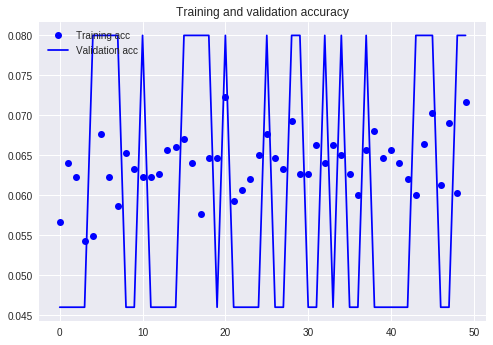

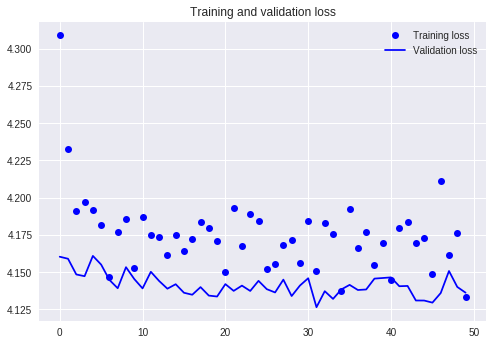

In [33]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [41]:
print(history.history.keys())

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


In [34]:
print(test_dir)
from keras.preprocessing.image import ImageDataGenerator
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(200, 200),
        batch_size=20,
        classes=None,
        class_mode=None)


/content/plankton/test
Found 130400 images belonging to 1 classes.


In [0]:
from keras.models import load_model
saved_model = load_model('plankton_1.h5')

In [0]:
import numpy as np
res = model.predict_generator(test_generator)


In [30]:
len(test_generator.filenames)

130400

In [60]:
res[100][5]

0.021835314

In [42]:
import pandas as pd
image_index = [x.replace("test/","") for x in test_generator.filenames]
df = pd.DataFrame(data=res, columns=[*train_generator.class_indices],index=image_index)
df.head()

,acantharia_protist,acantharia_protist_big_center,acantharia_protist_halo,amphipods,appendicularian_fritillaridae,appendicularian_s_shape,appendicularian_slight_curve,appendicularian_straight,artifacts,artifacts_edge,...,trichodesmium_tuft,trochophore_larvae,tunicate_doliolid,tunicate_doliolid_nurse,tunicate_partial,tunicate_salp,tunicate_salp_chains,unknown_blobs_and_smudges,unknown_sticks,unknown_unclassified
1.jpg,0.028449,0.000611,0.002634,0.001587,0.000595,0.021835,0.019459,0.00934,0.011754,0.006463,...,0.019762,0.001103,0.01486,0.01423,0.01126,0.00779,0.002407,0.009504,0.005515,0.016659
10.jpg,0.028449,0.000611,0.002634,0.001587,0.000595,0.021835,0.019459,0.00934,0.011754,0.006463,...,0.019762,0.001103,0.01486,0.01423,0.01126,0.00779,0.002407,0.009504,0.005515,0.016659
100.jpg,0.028449,0.000611,0.002634,0.001587,0.000595,0.021835,0.019459,0.00934,0.011754,0.006463,...,0.019762,0.001103,0.01486,0.01423,0.01126,0.00779,0.002407,0.009504,0.005515,0.016659
1000.jpg,0.028449,0.000611,0.002634,0.001587,0.000595,0.021835,0.019459,0.00934,0.011754,0.006463,...,0.019762,0.001103,0.01486,0.01423,0.01126,0.00779,0.002407,0.009504,0.005515,0.016659
10000.jpg,0.028449,0.000611,0.002634,0.001587,0.000595,0.021835,0.019459,0.00934,0.011754,0.006463,...,0.019762,0.001103,0.01486,0.01423,0.01126,0.00779,0.002407,0.009504,0.005515,0.016659


In [43]:
#header = "acantharia_protist_big_center,acantharia_protist_halo,acantharia_protist,amphipods,appendicularian_fritillaridae,appendicularian_s_shape,appendicularian_slight_curve,appendicularian_straight,artifacts_edge,artifacts,chaetognath_non_sagitta,chaetognath_other,chaetognath_sagitta,chordate_type1,copepod_calanoid_eggs,copepod_calanoid_eucalanus,copepod_calanoid_flatheads,copepod_calanoid_frillyAntennae,copepod_calanoid_large_side_antennatucked,copepod_calanoid_large,copepod_calanoid_octomoms,copepod_calanoid_small_longantennae,copepod_calanoid,copepod_cyclopoid_copilia,copepod_cyclopoid_oithona_eggs,copepod_cyclopoid_oithona,copepod_other,crustacean_other,ctenophore_cestid,ctenophore_cydippid_no_tentacles,ctenophore_cydippid_tentacles,ctenophore_lobate,decapods,detritus_blob,detritus_filamentous,detritus_other,diatom_chain_string,diatom_chain_tube,echinoderm_larva_pluteus_brittlestar,echinoderm_larva_pluteus_early,echinoderm_larva_pluteus_typeC,echinoderm_larva_pluteus_urchin,echinoderm_larva_seastar_bipinnaria,echinoderm_larva_seastar_brachiolaria,echinoderm_seacucumber_auricularia_larva,echinopluteus,ephyra,euphausiids_young,euphausiids,fecal_pellet,fish_larvae_deep_body,fish_larvae_leptocephali,fish_larvae_medium_body,fish_larvae_myctophids,fish_larvae_thin_body,fish_larvae_very_thin_body,heteropod,hydromedusae_aglaura,hydromedusae_bell_and_tentacles,hydromedusae_h15,hydromedusae_haliscera_small_sideview,hydromedusae_haliscera,hydromedusae_liriope,hydromedusae_narco_dark,hydromedusae_narco_young,hydromedusae_narcomedusae,hydromedusae_other,hydromedusae_partial_dark,hydromedusae_shapeA_sideview_small,hydromedusae_shapeA,hydromedusae_shapeB,hydromedusae_sideview_big,hydromedusae_solmaris,hydromedusae_solmundella,hydromedusae_typeD_bell_and_tentacles,hydromedusae_typeD,hydromedusae_typeE,hydromedusae_typeF,invertebrate_larvae_other_A,invertebrate_larvae_other_B,jellies_tentacles,polychaete,protist_dark_center,protist_fuzzy_olive,protist_noctiluca,protist_other,protist_star,pteropod_butterfly,pteropod_theco_dev_seq,pteropod_triangle,radiolarian_chain,radiolarian_colony,shrimp_caridean,shrimp_sergestidae,shrimp_zoea,shrimp-like_other,siphonophore_calycophoran_abylidae,siphonophore_calycophoran_rocketship_adult,siphonophore_calycophoran_rocketship_young,siphonophore_calycophoran_sphaeronectes_stem,siphonophore_calycophoran_sphaeronectes_young,siphonophore_calycophoran_sphaeronectes,siphonophore_other_parts,siphonophore_partial,siphonophore_physonect_young,siphonophore_physonect,stomatopod,tornaria_acorn_worm_larvae,trichodesmium_bowtie,trichodesmium_multiple,trichodesmium_puff,trichodesmium_tuft,trochophore_larvae,tunicate_doliolid_nurse,tunicate_doliolid,tunicate_partial,tunicate_salp_chains,tunicate_salp,unknown_blobs_and_smudges,unknown_sticks,unknown_unclassified"
#df = df[['acantharia_protist_big_center,acantharia_protist_halo,acantharia_protist,amphipods,appendicularian_fritillaridae,appendicularian_s_shape,appendicularian_slight_curve,appendicularian_straight,artifacts_edge,artifacts,chaetognath_non_sagitta,chaetognath_other,chaetognath_sagitta,chordate_type1,copepod_calanoid_eggs,copepod_calanoid_eucalanus,copepod_calanoid_flatheads,copepod_calanoid_frillyAntennae,copepod_calanoid_large_side_antennatucked,copepod_calanoid_large,copepod_calanoid_octomoms,copepod_calanoid_small_longantennae,copepod_calanoid,copepod_cyclopoid_copilia,copepod_cyclopoid_oithona_eggs,copepod_cyclopoid_oithona,copepod_other,crustacean_other,ctenophore_cestid,ctenophore_cydippid_no_tentacles,ctenophore_cydippid_tentacles,ctenophore_lobate,decapods,detritus_blob,detritus_filamentous,detritus_other,diatom_chain_string,diatom_chain_tube,echinoderm_larva_pluteus_brittlestar,echinoderm_larva_pluteus_early,echinoderm_larva_pluteus_typeC,echinoderm_larva_pluteus_urchin,echinoderm_larva_seastar_bipinnaria,echinoderm_larva_seastar_brachiolaria,echinoderm_seacucumber_auricularia_larva,echinopluteus,ephyra,euphausiids_young,euphausiids,fecal_pellet,fish_larvae_deep_body,fish_larvae_leptocephali,fish_larvae_medium_body,fish_larvae_myctophids,fish_larvae_thin_body,fish_larvae_very_thin_body,heteropod,hydromedusae_aglaura,hydromedusae_bell_and_tentacles,hydromedusae_h15,hydromedusae_haliscera_small_sideview,hydromedusae_haliscera,hydromedusae_liriope,hydromedusae_narco_dark,hydromedusae_narco_young,hydromedusae_narcomedusae,hydromedusae_other,hydromedusae_partial_dark,hydromedusae_shapeA_sideview_small,hydromedusae_shapeA,hydromedusae_shapeB,hydromedusae_sideview_big,hydromedusae_solmaris,hydromedusae_solmundella,hydromedusae_typeD_bell_and_tentacles,hydromedusae_typeD,hydromedusae_typeE,hydromedusae_typeF,invertebrate_larvae_other_A,invertebrate_larvae_other_B,jellies_tentacles,polychaete,protist_dark_center,protist_fuzzy_olive,protist_noctiluca,protist_other,protist_star,pteropod_butterfly,pteropod_theco_dev_seq,pteropod_triangle,radiolarian_chain,radiolarian_colony,shrimp_caridean,shrimp_sergestidae,shrimp_zoea,shrimp-like_other,siphonophore_calycophoran_abylidae,siphonophore_calycophoran_rocketship_adult,siphonophore_calycophoran_rocketship_young,siphonophore_calycophoran_sphaeronectes_stem,siphonophore_calycophoran_sphaeronectes_young,siphonophore_calycophoran_sphaeronectes,siphonophore_other_parts,siphonophore_partial,siphonophore_physonect_young,siphonophore_physonect,stomatopod,tornaria_acorn_worm_larvae,trichodesmium_bowtie,trichodesmium_multiple,trichodesmium_puff,trichodesmium_tuft,trochophore_larvae,tunicate_doliolid_nurse,tunicate_doliolid,tunicate_partial,tunicate_salp_chains,tunicate_salp,unknown_blobs_and_smudges,unknown_sticks,unknown_unclassified']]
df.index.name = 'image'
df.head()

,acantharia_protist,acantharia_protist_big_center,acantharia_protist_halo,amphipods,appendicularian_fritillaridae,appendicularian_s_shape,appendicularian_slight_curve,appendicularian_straight,artifacts,artifacts_edge,...,trichodesmium_tuft,trochophore_larvae,tunicate_doliolid,tunicate_doliolid_nurse,tunicate_partial,tunicate_salp,tunicate_salp_chains,unknown_blobs_and_smudges,unknown_sticks,unknown_unclassified
image,,,,,,,,,,,,,,,,,,,,,
1.jpg,0.028449,0.000611,0.002634,0.001587,0.000595,0.021835,0.019459,0.00934,0.011754,0.006463,...,0.019762,0.001103,0.01486,0.01423,0.01126,0.00779,0.002407,0.009504,0.005515,0.016659
10.jpg,0.028449,0.000611,0.002634,0.001587,0.000595,0.021835,0.019459,0.00934,0.011754,0.006463,...,0.019762,0.001103,0.01486,0.01423,0.01126,0.00779,0.002407,0.009504,0.005515,0.016659
100.jpg,0.028449,0.000611,0.002634,0.001587,0.000595,0.021835,0.019459,0.00934,0.011754,0.006463,...,0.019762,0.001103,0.01486,0.01423,0.01126,0.00779,0.002407,0.009504,0.005515,0.016659
1000.jpg,0.028449,0.000611,0.002634,0.001587,0.000595,0.021835,0.019459,0.00934,0.011754,0.006463,...,0.019762,0.001103,0.01486,0.01423,0.01126,0.00779,0.002407,0.009504,0.005515,0.016659
10000.jpg,0.028449,0.000611,0.002634,0.001587,0.000595,0.021835,0.019459,0.00934,0.011754,0.006463,...,0.019762,0.001103,0.01486,0.01423,0.01126,0.00779,0.002407,0.009504,0.005515,0.016659


In [48]:
df.to_csv("/content/plankton/result.csv", encoding='utf-8',index=image_index)
result2 = pd.read_csv('/content/plankton/result.csv')
result2.columns

Index(['image', 'acantharia_protist', 'acantharia_protist_big_center',
       'acantharia_protist_halo', 'amphipods', 'appendicularian_fritillaridae',
       'appendicularian_s_shape', 'appendicularian_slight_curve',
       'appendicularian_straight', 'artifacts',
       ...
       'trichodesmium_tuft', 'trochophore_larvae', 'tunicate_doliolid',
       'tunicate_doliolid_nurse', 'tunicate_partial', 'tunicate_salp',
       'tunicate_salp_chains', 'unknown_blobs_and_smudges', 'unknown_sticks',
       'unknown_unclassified'],
      dtype='object', length=122)

In [49]:
!kaggle competitions submit -c datasciencebowl -f /content/plankton/result.csv -m "50 epoch + augmented data generation+ add layers"

Successfully submitted to National Data Science Bowl